In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from numpy import sqrt 
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
# from keras.models import Sequential
# from keras.layers import Dense
from torch.utils.data import DataLoader

from tqdm import tqdm

In [2]:
device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


In [3]:
data = pd.read_csv('train_cleaned.csv')
test_data = pd.read_csv('test_public.csv')

In [4]:
data.head()
data.shape

(217956, 23)

In [5]:
test_data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False


In [6]:
print(data.columns)
print(test_data.columns)

Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'TAXI_ID', 'TIMESTAMP',
       'END_TIMESTAMP', 'tripTimeSec', 'MON', 'DAY', 'WK_DAY', 'START_HR',
       'START_MIN', 'START_QTR', 'END_HR', 'END_MIN', 'END_QTR',
       'ORIGIN_STAND', 'STAND_LAT', 'STAND_LONG', 'IS_HOSPITAL', 'IS_STADIUM',
       'IS_UNIV', 'POLYLINE'],
      dtype='object')
Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA'],
      dtype='object')


In [7]:
def parse_time(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.weekday()
test_data[["YR", "MON", "DAY", "START_HR", "START_MIN", "WK_DAY"]] = test_data[['TIMESTAMP']].apply(parse_time, axis=1, result_type="expand")
print(data.columns)
print(test_data.columns)

Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'TAXI_ID', 'TIMESTAMP',
       'END_TIMESTAMP', 'tripTimeSec', 'MON', 'DAY', 'WK_DAY', 'START_HR',
       'START_MIN', 'START_QTR', 'END_HR', 'END_MIN', 'END_QTR',
       'ORIGIN_STAND', 'STAND_LAT', 'STAND_LONG', 'IS_HOSPITAL', 'IS_STADIUM',
       'IS_UNIV', 'POLYLINE'],
      dtype='object')
Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'YR', 'MON', 'DAY', 'START_HR',
       'START_MIN', 'WK_DAY'],
      dtype='object')


In [8]:
def minute_to_quarter(x):
    if(x >= 0 and x < 15):
        return 1
    elif(x >= 15 and x < 30):
        return 2
    elif(x >= 30 and x < 45):
        return 3
    else:
        return 4
test_data["START_QTR"] = test_data["START_MIN"].apply(minute_to_quarter)
print(data.columns)
print(test_data.columns)

Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'TAXI_ID', 'TIMESTAMP',
       'END_TIMESTAMP', 'tripTimeSec', 'MON', 'DAY', 'WK_DAY', 'START_HR',
       'START_MIN', 'START_QTR', 'END_HR', 'END_MIN', 'END_QTR',
       'ORIGIN_STAND', 'STAND_LAT', 'STAND_LONG', 'IS_HOSPITAL', 'IS_STADIUM',
       'IS_UNIV', 'POLYLINE'],
      dtype='object')
Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'YR', 'MON', 'DAY', 'START_HR',
       'START_MIN', 'WK_DAY', 'START_QTR'],
      dtype='object')


In [9]:
for index, value in test_data['ORIGIN_STAND'].iteritems():
    if float(value) == 33.0 or float(value) == 39.0:
        test_data.loc[index, 'IS_HOSPITAL'] = 1
    else:
        test_data.loc[index, 'IS_HOSPITAL'] = 0
    indexes = [2.0, 3.0, 26.0, 28.0, 44.0]
    if float(value) in indexes:
        test_data.loc[index, 'IS_STADIUM'] = 1
    else:
        test_data.loc[index, 'IS_STADIUM'] = 0
    indexes = [1.0, 25.0, 33.0, 42.0, 49.0]
    if float(value) in indexes:
        test_data.loc[index, 'IS_UNIV'] = 1
    else:
        test_data.loc[index, 'IS_UNIV'] = 0
test_data.head()

/tmp/ipykernel_298/1727982855.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in test_data['ORIGIN_STAND'].iteritems():


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,YR,MON,DAY,START_HR,START_MIN,WK_DAY,START_QTR,IS_HOSPITAL,IS_STADIUM,IS_UNIV
0,T1,B,NaN,15.0,20000542,1408039037,A,False,2014,8,14,17,57,3,4,0.0,0.0,0.0
1,T2,B,NaN,57.0,20000108,1408038611,A,False,2014,8,14,17,50,3,4,0.0,0.0,0.0
2,T3,B,NaN,15.0,20000370,1408038568,A,False,2014,8,14,17,49,3,4,0.0,0.0,0.0
3,T4,B,NaN,53.0,20000492,1408039090,A,False,2014,8,14,17,58,3,4,0.0,0.0,0.0
4,T5,B,NaN,18.0,20000621,1408039177,A,False,2014,8,14,17,59,3,4,0.0,0.0,0.0


In [10]:
print(data.columns)
print(test_data.columns)

Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'TAXI_ID', 'TIMESTAMP',
       'END_TIMESTAMP', 'tripTimeSec', 'MON', 'DAY', 'WK_DAY', 'START_HR',
       'START_MIN', 'START_QTR', 'END_HR', 'END_MIN', 'END_QTR',
       'ORIGIN_STAND', 'STAND_LAT', 'STAND_LONG', 'IS_HOSPITAL', 'IS_STADIUM',
       'IS_UNIV', 'POLYLINE'],
      dtype='object')
Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'YR', 'MON', 'DAY', 'START_HR',
       'START_MIN', 'WK_DAY', 'START_QTR', 'IS_HOSPITAL', 'IS_STADIUM',
       'IS_UNIV'],
      dtype='object')


In [11]:
data = data.drop(['POLYLINE', 'STAND_LAT', 'STAND_LONG', 'ORIGIN_CALL', 'TRIP_ID','TIMESTAMP', 'END_TIMESTAMP', 'END_HR', 'END_MIN', 'END_QTR'], axis=1)
data.head()

,CALL_TYPE,TAXI_ID,tripTimeSec,MON,DAY,WK_DAY,START_HR,START_MIN,START_QTR,ORIGIN_STAND,IS_HOSPITAL,IS_STADIUM,IS_UNIV
0,B,20000603,375,8,1,3,2,1,1,13.0,0.0,0.0,0.0
1,B,20000372,510,8,1,3,2,2,1,23.0,0.0,0.0,0.0
2,A,20000488,735,8,1,3,2,3,1,0.0,0.0,0.0,0.0
3,B,20000686,750,8,1,3,2,4,1,23.0,0.0,0.0,0.0
4,C,20000678,555,8,1,3,2,4,1,0.0,0.0,0.0,0.0


In [12]:
test_data = test_data.drop(['TRIP_ID', 'ORIGIN_CALL', 'YR', 'DAY_TYPE', 'MISSING_DATA', 'TIMESTAMP'], axis = 1)
test_data.head()
print(np.sort(test_data.columns))
print(np.sort(data.columns))

['CALL_TYPE' 'DAY' 'IS_HOSPITAL' 'IS_STADIUM' 'IS_UNIV' 'MON'
 'ORIGIN_STAND' 'START_HR' 'START_MIN' 'START_QTR' 'TAXI_ID' 'WK_DAY']
['CALL_TYPE' 'DAY' 'IS_HOSPITAL' 'IS_STADIUM' 'IS_UNIV' 'MON'
 'ORIGIN_STAND' 'START_HR' 'START_MIN' 'START_QTR' 'TAXI_ID' 'WK_DAY'
 'tripTimeSec']


In [13]:
data = data[np.sort(data.columns)]
test_data = test_data[np.sort(test_data.columns)]
print(data.shape)
data.head()

(217956, 13)


,CALL_TYPE,DAY,IS_HOSPITAL,IS_STADIUM,IS_UNIV,MON,ORIGIN_STAND,START_HR,START_MIN,START_QTR,TAXI_ID,WK_DAY,tripTimeSec
0,B,1,0.0,0.0,0.0,8,13.0,2,1,1,20000603,3,375
1,B,1,0.0,0.0,0.0,8,23.0,2,2,1,20000372,3,510
2,A,1,0.0,0.0,0.0,8,0.0,2,3,1,20000488,3,735
3,B,1,0.0,0.0,0.0,8,23.0,2,4,1,20000686,3,750
4,C,1,0.0,0.0,0.0,8,0.0,2,4,1,20000678,3,555


In [14]:
print(test_data.shape)
test_data.head()

(320, 12)


,CALL_TYPE,DAY,IS_HOSPITAL,IS_STADIUM,IS_UNIV,MON,ORIGIN_STAND,START_HR,START_MIN,START_QTR,TAXI_ID,WK_DAY
0,B,14,0.0,0.0,0.0,8,15.0,17,57,4,20000542,3
1,B,14,0.0,0.0,0.0,8,57.0,17,50,4,20000108,3
2,B,14,0.0,0.0,0.0,8,15.0,17,49,4,20000370,3
3,B,14,0.0,0.0,0.0,8,53.0,17,58,4,20000492,3
4,B,14,0.0,0.0,0.0,8,18.0,17,59,4,20000621,3


In [15]:
#print(data.columns)

In [16]:
def make_mapping(ser):
    '''creates a mapping'''
    mapping = dict(zip(ser.unique(), np.arange(len(ser.unique()))))
    return mapping

def encode(ser, mapping):
    '''encodes a series based on a given mapping '''
    return ser.map(mapping)


encode_cols = ['CALL_TYPE', 'ORIGIN_STAND', 'TAXI_ID', 'IS_HOSPITAL', 'IS_STADIUM', 'IS_UNIV']

for col in encode_cols:
    dat_col = data[col]
    test_col = test_data[col]
    
    # make sure the test and the train data have the same mapping!
    combined = pd.concat([dat_col, test_col])
    
    # prevent weird encoding imbalance if there are some encodings that appear in 
    # one but not the other
    combined = combined.sample(frac=1)
    
    mapping = make_mapping(combined)
    
    data[col] = encode(dat_col, mapping)
    test_data[col] = encode(test_col, mapping)



In [17]:
data.head()

,CALL_TYPE,DAY,IS_HOSPITAL,IS_STADIUM,IS_UNIV,MON,ORIGIN_STAND,START_HR,START_MIN,START_QTR,TAXI_ID,WK_DAY,tripTimeSec
0,0,1,0,0,0,8,25,2,1,1,212,3,375
1,0,1,0,0,0,8,11,2,2,1,81,3,510
2,2,1,0,0,0,8,2,2,3,1,100,3,735
3,0,1,0,0,0,8,11,2,4,1,43,3,750
4,1,1,0,0,0,8,2,2,4,1,36,3,555


In [18]:
test_data.head()

,CALL_TYPE,DAY,IS_HOSPITAL,IS_STADIUM,IS_UNIV,MON,ORIGIN_STAND,START_HR,START_MIN,START_QTR,TAXI_ID,WK_DAY
0,0,14,0,0,0,8,4,17,57,4,11,3
1,0,14,0,0,0,8,12,17,50,4,48,3
2,0,14,0,0,0,8,4,17,49,4,2,3
3,0,14,0,0,0,8,3,17,58,4,196,3
4,0,14,0,0,0,8,29,17,59,4,175,3


In [19]:
test_data.to_csv('test_cleaned.csv', index=False)

In [20]:
#['CALL_TYPE', 'DAY', 'IS_HOSPITAL', 'IS_STADIUM', 'IS_UNIV', 'MON',
 #      'ORIGIN_STAND', 'START_HR', 'START_MIN', 'START_QTR', 'TAXI_ID',
  #     'WK_DAY', 'tripTimeSec']

In [21]:
# Create X and y for train and test!
selected_cols = ['CALL_TYPE', 'IS_HOSPITAL', 'IS_STADIUM', 'IS_UNIV', 'TAXI_ID', 'DAY', 'MON','START_HR', 'START_QTR', 'WK_DAY']
#data = data.sample(frac = 0.5)
X = data.drop(['tripTimeSec'],axis=1)[selected_cols].values
y = data['tripTimeSec'].values
DAT_FEATURES = X.shape[1]
print(X.shape)
# DO NOT SHUFFLE!
X_test = test_data[selected_cols].values

(217956, 10)


In [22]:
#len(np.unique(y, return_counts=True)[0])

In [23]:
# PredictorScaler=StandardScaler()
# TargetVarScaler=StandardScaler()
 
# # Storing the fit object for later reference
# PredictorScalerFit=PredictorScaler.fit(X)
# TargetVarScalerFit=TargetVarScaler.fit(y.reshape(-1, 1))

# X=PredictorScalerFit.transform(X)
# y=TargetVarScalerFit.transform(y.reshape(-1, 1))

In [24]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(DAT_FEATURES, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.3)
        self.dropout4 = nn.Dropout(p=0.4)
        self.dropout5 = nn.Dropout(p=0.1)
        self.batchNorm12 = nn.BatchNorm1d(256)
        self.batchNorm23 = nn.BatchNorm1d(1024)
        self.batchNorm34 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        #x = self.batchNorm12(x)
        x = self.dropout5(x)
        x = self.relu(self.fc2(x))
        #x = self.batchNorm23(x)
        #x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        #x = self.batchNorm34(x)
        #x = self.dropout5(x)
        x = self.fc4(x)
        return x


In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
model = MyModel()#.cuda()
print(count_parameters(model))

145313


In [26]:
import torch
from torch.utils.data import DataLoader, Dataset

#Define your custom dataset
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return len(self.data)

#Assuming you have your data and labels as numpy arrays or tensors
#Create an instance of your dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.98)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)
dataset_train = MyDataset(X_train, y_train)
dataset_val = MyDataset(X_val, y_val)

#Define the batch size for training and validation
batch_size = 200


#Create the dataloaders
dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)  # For training
validation_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)  # For validation


(213596, 10)
(4360, 10)
(213596,)
(4360,)


717.9743300436338
413.7303443029251
2775


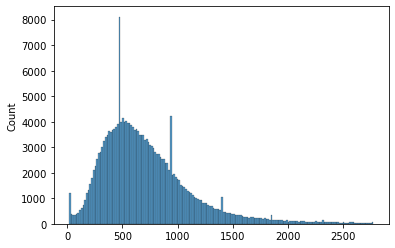

In [27]:
sns.histplot(y_train)
print(y_train.mean())
print(y_train.std())
print(np.amax(y_train))

727.052752293578
417.8890753863844
2760


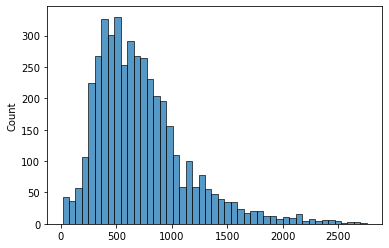

In [28]:
sns.histplot(y_val)
print(y_val.mean())
print(y_val.std())
print(np.amax(y_val))

In [29]:
learning_rates = [1e-3, 1e-4, 1e-3, 3e-3, 0.01, 0.03, 0.1, 0.3, 1.0]
lr_dict = dict()
epoch_cnt = []
losses = []

for lr in learning_rates:
    # Create an instance of your model
    model = MyModel().to(device)

    # Define the loss function
    criterion = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr)

    # Training loop
    num_epochs = 100

    # For early stopping
    best_val_loss = float('inf')
    patience = 5  # Number of epochs to wait for improvement before stopping
    epochs_without_improvement = 0

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0

        # Set the model to training mode
        model.train()

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.float().to(device)
            targets = targets.float().to(device)
            # Forward pass
            outputs = model(inputs)
            outputs = outputs.float()
            loss = criterion(outputs, targets.reshape(targets.shape[0], 1))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate the training loss
            train_loss += loss.item()

        # Calculate average training loss for the epoch
        train_loss /= len(dataloader)

        # Set the model to evaluation mode for validation
        model.eval()

        # Validation loop
        val_loss = 0.0

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(validation_dataloader):
                inputs = inputs.float().to(device)
                targets = targets.float().to(device).unsqueeze(axis=1)
                # Forward pass
                outputs = model(inputs)
                #print(outputs)
                loss = criterion(outputs, targets.reshape(targets.shape[0], 1))

                # Accumulate the validation loss
                val_loss += loss.item()

            # Calculate average validation loss for the epoch
            val_loss /= len(validation_dataloader)

        # Print the loss for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {train_loss**.5:.4f}, \         Validation Loss: {(val_loss**.5):.4f}")
        epoch_cnt.append(epoch + 1)
        losses.append(train_loss**.5)
        # Check for early stopping
        if val_loss < best_val_loss - 0.1:
            best_val_loss = round(val_loss)
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement == patience:
                print(f"Stopping training due to lack of improvement in validation loss for {patience} epochs.")
                break
    lr_dict[lr] = best_val_loss
    break


  1%|          | 1/100 [00:03<06:21,  3.85s/it]

Epoch 1/100: Training Loss: 424.3393, \         Validation Loss: 411.6380


  2%|▏         | 2/100 [00:06<05:30,  3.38s/it]

Epoch 2/100: Training Loss: 409.2148, \         Validation Loss: 411.0740


  3%|▎         | 3/100 [00:10<05:16,  3.26s/it]

Epoch 3/100: Training Loss: 408.9782, \         Validation Loss: 410.8952


  4%|▍         | 4/100 [00:13<05:17,  3.30s/it]

Epoch 4/100: Training Loss: 408.5693, \         Validation Loss: 409.9523


  5%|▌         | 5/100 [00:16<05:23,  3.40s/it]

Epoch 5/100: Training Loss: 408.1830, \         Validation Loss: 410.0385


  6%|▌         | 6/100 [00:20<05:18,  3.39s/it]

Epoch 6/100: Training Loss: 408.0193, \         Validation Loss: 410.1667


  7%|▋         | 7/100 [00:23<05:14,  3.38s/it]

Epoch 7/100: Training Loss: 407.8355, \         Validation Loss: 409.8796


  8%|▊         | 8/100 [00:26<05:04,  3.31s/it]

Epoch 8/100: Training Loss: 407.6296, \         Validation Loss: 409.3380


  9%|▉         | 9/100 [00:30<05:02,  3.33s/it]

Epoch 9/100: Training Loss: 407.6120, \         Validation Loss: 409.2037


 10%|█         | 10/100 [00:33<04:59,  3.33s/it]

Epoch 10/100: Training Loss: 407.4373, \         Validation Loss: 410.2749


 11%|█         | 11/100 [00:36<04:37,  3.12s/it]

Epoch 11/100: Training Loss: 407.5434, \         Validation Loss: 408.6266


 12%|█▏        | 12/100 [00:39<04:29,  3.06s/it]

Epoch 12/100: Training Loss: 406.7885, \         Validation Loss: 408.7122


 13%|█▎        | 13/100 [00:42<04:34,  3.15s/it]

Epoch 13/100: Training Loss: 406.9471, \         Validation Loss: 408.0358


 14%|█▍        | 14/100 [00:45<04:39,  3.25s/it]

Epoch 14/100: Training Loss: 406.7314, \         Validation Loss: 408.2014


 15%|█▌        | 15/100 [00:49<04:42,  3.32s/it]

Epoch 15/100: Training Loss: 406.4569, \         Validation Loss: 407.7705


 16%|█▌        | 16/100 [00:53<04:45,  3.40s/it]

Epoch 16/100: Training Loss: 406.3717, \         Validation Loss: 408.4173


 17%|█▋        | 17/100 [00:56<04:42,  3.40s/it]

Epoch 17/100: Training Loss: 406.1282, \         Validation Loss: 407.4112


 18%|█▊        | 18/100 [00:59<04:39,  3.41s/it]

Epoch 18/100: Training Loss: 405.9024, \         Validation Loss: 407.7816


 19%|█▉        | 19/100 [01:03<04:36,  3.41s/it]

Epoch 19/100: Training Loss: 405.8730, \         Validation Loss: 409.4164


 20%|██        | 20/100 [01:06<04:27,  3.35s/it]

Epoch 20/100: Training Loss: 405.7539, \         Validation Loss: 407.4203


 21%|██        | 21/100 [01:09<04:17,  3.26s/it]

Epoch 21/100: Training Loss: 405.5069, \         Validation Loss: 407.2259


 22%|██▏       | 22/100 [01:12<04:06,  3.17s/it]

Epoch 22/100: Training Loss: 405.3740, \         Validation Loss: 407.1467


 23%|██▎       | 23/100 [01:15<04:09,  3.23s/it]

Epoch 23/100: Training Loss: 405.4478, \         Validation Loss: 406.9824


 24%|██▍       | 24/100 [01:19<04:12,  3.32s/it]

Epoch 24/100: Training Loss: 405.3406, \         Validation Loss: 407.2294


 25%|██▌       | 25/100 [01:22<04:13,  3.38s/it]

Epoch 25/100: Training Loss: 405.2067, \         Validation Loss: 405.9448


 26%|██▌       | 26/100 [01:26<04:12,  3.41s/it]

Epoch 26/100: Training Loss: 405.0758, \         Validation Loss: 406.2896


 27%|██▋       | 27/100 [01:29<04:11,  3.44s/it]

Epoch 27/100: Training Loss: 405.1147, \         Validation Loss: 408.6770


 28%|██▊       | 28/100 [01:33<04:03,  3.39s/it]

Epoch 28/100: Training Loss: 404.8905, \         Validation Loss: 408.0072


 29%|██▉       | 29/100 [01:36<04:07,  3.49s/it]

Epoch 29/100: Training Loss: 404.8693, \         Validation Loss: 405.7659


 30%|███       | 30/100 [01:40<04:07,  3.54s/it]

Epoch 30/100: Training Loss: 404.6976, \         Validation Loss: 406.2722


 31%|███       | 31/100 [01:43<03:58,  3.45s/it]

Epoch 31/100: Training Loss: 404.5847, \         Validation Loss: 405.7051


 32%|███▏      | 32/100 [01:47<03:52,  3.42s/it]

Epoch 32/100: Training Loss: 404.4919, \         Validation Loss: 405.1259


 33%|███▎      | 33/100 [01:50<03:53,  3.48s/it]

Epoch 33/100: Training Loss: 404.5038, \         Validation Loss: 407.2323


 34%|███▍      | 34/100 [01:54<03:50,  3.49s/it]

Epoch 34/100: Training Loss: 404.3945, \         Validation Loss: 405.6655


 35%|███▌      | 35/100 [01:57<03:44,  3.46s/it]

Epoch 35/100: Training Loss: 404.2833, \         Validation Loss: 405.2079


 36%|███▌      | 36/100 [02:01<03:41,  3.45s/it]

Epoch 36/100: Training Loss: 404.0247, \         Validation Loss: 405.3151


 37%|███▋      | 37/100 [02:04<03:38,  3.47s/it]

Epoch 37/100: Training Loss: 404.1064, \         Validation Loss: 405.0794


 38%|███▊      | 38/100 [02:08<03:37,  3.51s/it]

Epoch 38/100: Training Loss: 404.0322, \         Validation Loss: 405.1254


 39%|███▉      | 39/100 [02:11<03:30,  3.45s/it]

Epoch 39/100: Training Loss: 404.1071, \         Validation Loss: 405.0974


 40%|████      | 40/100 [02:14<03:24,  3.40s/it]

Epoch 40/100: Training Loss: 404.1561, \         Validation Loss: 407.2073


 41%|████      | 41/100 [02:18<03:25,  3.48s/it]

Epoch 41/100: Training Loss: 403.6808, \         Validation Loss: 404.9013


 42%|████▏     | 42/100 [02:21<03:19,  3.43s/it]

Epoch 42/100: Training Loss: 403.8310, \         Validation Loss: 404.9472


 43%|████▎     | 43/100 [02:25<03:17,  3.46s/it]

Epoch 43/100: Training Loss: 403.9794, \         Validation Loss: 405.8450


 44%|████▍     | 44/100 [02:28<03:08,  3.36s/it]

Epoch 44/100: Training Loss: 403.8582, \         Validation Loss: 406.1382


 45%|████▌     | 45/100 [02:31<03:05,  3.38s/it]

Epoch 45/100: Training Loss: 403.8688, \         Validation Loss: 404.7168


 46%|████▌     | 46/100 [02:35<03:02,  3.39s/it]

Epoch 46/100: Training Loss: 403.7105, \         Validation Loss: 404.8826


 47%|████▋     | 47/100 [02:38<03:02,  3.43s/it]

Epoch 47/100: Training Loss: 403.7673, \         Validation Loss: 405.6444


 48%|████▊     | 48/100 [02:41<02:53,  3.33s/it]

Epoch 48/100: Training Loss: 403.5503, \         Validation Loss: 404.5835


 49%|████▉     | 49/100 [02:45<02:50,  3.35s/it]

Epoch 49/100: Training Loss: 403.5687, \         Validation Loss: 405.1600


 50%|█████     | 50/100 [02:48<02:50,  3.40s/it]

Epoch 50/100: Training Loss: 403.5433, \         Validation Loss: 404.4564


 51%|█████     | 51/100 [02:51<02:41,  3.30s/it]

Epoch 51/100: Training Loss: 403.6350, \         Validation Loss: 407.9778


 52%|█████▏    | 52/100 [02:55<02:36,  3.26s/it]

Epoch 52/100: Training Loss: 403.6552, \         Validation Loss: 404.3126


 53%|█████▎    | 53/100 [02:58<02:32,  3.24s/it]

Epoch 53/100: Training Loss: 403.5208, \         Validation Loss: 405.2642


 54%|█████▍    | 54/100 [03:01<02:29,  3.25s/it]

Epoch 54/100: Training Loss: 403.6395, \         Validation Loss: 404.8192


 55%|█████▌    | 55/100 [03:04<02:27,  3.28s/it]

Epoch 55/100: Training Loss: 403.4070, \         Validation Loss: 405.3232


 56%|█████▌    | 56/100 [03:08<02:24,  3.29s/it]

Epoch 56/100: Training Loss: 403.4136, \         Validation Loss: 404.1870


 57%|█████▋    | 57/100 [03:11<02:19,  3.25s/it]

Epoch 57/100: Training Loss: 403.5303, \         Validation Loss: 406.3148


 58%|█████▊    | 58/100 [03:14<02:13,  3.17s/it]

Epoch 58/100: Training Loss: 403.4967, \         Validation Loss: 405.6374


 59%|█████▉    | 59/100 [03:18<02:17,  3.35s/it]

Epoch 59/100: Training Loss: 403.1014, \         Validation Loss: 404.6667


 60%|██████    | 60/100 [03:20<02:08,  3.21s/it]

Epoch 60/100: Training Loss: 403.3196, \         Validation Loss: 404.0448


 61%|██████    | 61/100 [03:23<02:00,  3.08s/it]

Epoch 61/100: Training Loss: 403.1878, \         Validation Loss: 404.7847


 62%|██████▏   | 62/100 [03:26<01:53,  3.00s/it]

Epoch 62/100: Training Loss: 403.3342, \         Validation Loss: 405.5902


 63%|██████▎   | 63/100 [03:29<01:48,  2.94s/it]

Epoch 63/100: Training Loss: 403.2255, \         Validation Loss: 403.9326


 64%|██████▍   | 64/100 [03:32<01:44,  2.90s/it]

Epoch 64/100: Training Loss: 403.1753, \         Validation Loss: 404.7824


 65%|██████▌   | 65/100 [03:35<01:40,  2.88s/it]

Epoch 65/100: Training Loss: 403.1180, \         Validation Loss: 404.7360


 66%|██████▌   | 66/100 [03:37<01:35,  2.81s/it]

Epoch 66/100: Training Loss: 403.1106, \         Validation Loss: 405.5131


 67%|██████▋   | 67/100 [03:40<01:30,  2.75s/it]

Epoch 67/100: Training Loss: 403.0177, \         Validation Loss: 406.0608


 67%|██████▋   | 67/100 [03:42<01:49,  3.33s/it]

Epoch 68/100: Training Loss: 403.2228, \         Validation Loss: 408.1722
Stopping training due to lack of improvement in validation loss for 5 epochs.


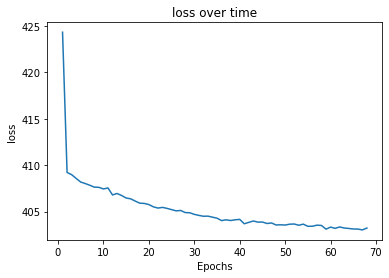

In [38]:
plt.plot(epoch_cnt, losses)
plt.title("loss over time")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

In [31]:

X_test= torch.tensor(X_test).float().cuda()
#print(X)
output =model(X_test)
print(output)

tensor([[772.5705],
        [757.7123],
        [787.5950],
        [723.7085],
        [726.1119],
        [762.7115],
        [727.3709],
        [772.6344],
        [722.4496],
        [751.2142],
        [718.7239],
        [798.8524],
        [798.0546],
        [803.2037],
        [802.1844],
        [797.1928],
        [806.1272],
        [835.4033],
        [740.8999],
        [946.1329],
        [764.0679],
        [864.3622],
        [781.4163],
        [719.6763],
        [764.3636],
        [765.5667],
        [772.6790],
        [729.2021],
        [729.6600],
        [730.5287],
        [730.1353],
        [725.9976],
        [794.9838],
        [791.2413],
        [831.9380],
        [791.5630],
        [763.2421],
        [722.5640],
        [720.1398],
        [769.3226],
        [730.6181],
        [789.3610],
        [801.2416],
        [719.9852],
        [770.1631],
        [760.6156],
        [803.7966],
        [790.1965],
        [629.7144],
        [754.3870],


<AxesSubplot:ylabel='Count'>

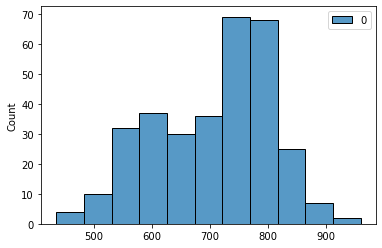

In [32]:
sns.histplot(output.cpu().detach().numpy())

<AxesSubplot:ylabel='Count'>

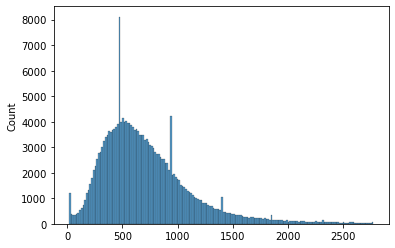

In [33]:
sns.histplot(y_train)

predictions_train = random_regressor.predict(X_train)
print(predictions_train)
print(y_train)

predictions_test = random_regressor.predict(X_val)

print(predictions_test)
print(y_val)

loss_train = sqrt(mean_squared_error(predictions_train, y_train))
loss_test = sqrt(mean_squared_error(predictions_test, y_val))
if loss_test >= baseline_loss_test or loss_train <= baseline_loss_train:
    print(loss_train)
    print(loss_test)
    print('This model aint worth jack')
#worthless model if either above 70 million

In [34]:
torch.save(model.state_dict(), 'test.pt')

In [35]:

travel = pd.read_csv('sampleSubmission.csv')
travel['TRAVEL_TIME'] = output.cpu().detach().numpy()
travel.to_csv('sampleSubmission.csv', index = False)